# Neural Style Transfer Data Owner

In [1]:
import syft as sy

## PART 1: Connect to a Remote Duet Server

As the data scientist, you want to perform data science on data that is sitting in the Data Owner's Duet server (in their Notebook).

In order to do this, we must run the code that the Data Owner sends us, which importantly includes their Duet Session ID. This will create a direct connection from my notebook to the remote Duet server. Once the connection is established all traffic is sent directly between the two nodes.

Let's run the code below and follow the instructions it gives.

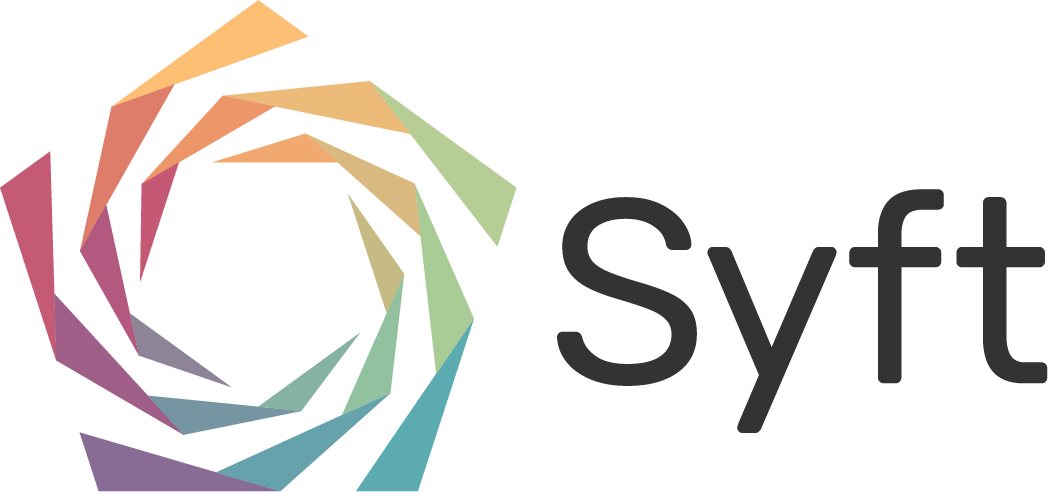

🎤  🎸  ♪♪♪ Starting Duet ♫♫♫  🎻  🎹

♫♫♫ > DISCLAIMER: Duet is an experimental feature currently in beta.
♫♫♫ >             Use at your own risk.
♫♫♫ >
♫♫♫ > Punching through firewall to OpenGrid Network Node at:
♫♫♫ > http://ec2-18-216-8-163.us-east-2.compute.amazonaws.com:5000
♫♫♫ >
♫♫♫ > ...waiting for response from OpenGrid Network... DONE!
♫♫♫ >
♫♫♫ > STEP 1: Send the following code to your Duet Partner!

import syft as sy
duet = sy.duet("2ad872f7d668281841d79c768450e947")

♫♫♫ > STEP 2: Running the code above will print out a 'Client ID'.
♫♫♫ >         Have your duet partner send it to you and enter it below!

Running loopback mode. Use sy.join_duet(loopback=True) on the other side.
♫♫♫ > Connecting...
♫♫♫ > ...using a running event loop...

♫♫♫ > CONNECTED!

♫♫♫ > DUET LIVE STATUS  -  Objects: 7  Requests: 0   Messages: 70                                ast.literal_eval failed to parse part: . unexpected EOF while parsing (<unknown>, line 0)
♫♫♫ > DUET LIVE STATUS  -  Objects: 7  

In [2]:
duet = sy.launch_duet(loopback=True)

## PART 2: Launch a Duet Server and Connect

In [4]:
import torch
import re
from torchvision import transforms

from original.neural_style import utils
# from original.neural_style.vgg import Vgg16
# from original.neural_style.transformer_net import TransformerNet # redefined below

## Load the already pre-trained model (with the style it was trained)

In [5]:
%run "original/download_saved_models.py"

100.0%


In [8]:
# from MNIST notebooks for example reference
# class SyNet(sy.Module):
#     def __init__(self, torch_ref):
#         super(SyNet, self).__init__(torch_ref=torch_ref)
#         self.conv1 = self.torch_ref.nn.Conv2d(1, 32, 3, 1)
#         self.conv2 = self.torch_ref.nn.Conv2d(32, 64, 3, 1) 
#         self.dropout1 = self.torch_ref.nn.Dropout2d(0.25)
#         self.dropout2 = self.torch_ref.nn.Dropout2d(0.5)
#         self.fc1 = self.torch_ref.nn.Linear(9216, 128)
#         self.fc2 = self.torch_ref.nn.Linear(128, 10)

#     def forward(self, x):
#         x = self.conv1(x)
#         x = self.torch_ref.nn.functional.relu(x)
#         x = self.conv2(x)
#         x = self.torch_ref.nn.functional.relu(x)
#         x = self.torch_ref.nn.functional.max_pool2d(x, 2)
#         x = self.dropout1(x)
#         x = self.torch_ref.flatten(x, 1)
#         x = self.fc1(x)
#         x = self.torch_ref.nn.functional.relu(x)
#         x = self.dropout2(x)
#         x = self.fc2(x)
#         output = self.torch_ref.nn.functional.log_softmax(x, dim=1)
#         return output

class TransformerNet(sy.Module):
    def __init__(self, torch_ref):
        super(TransformerNet, self).__init__(torch_ref=torch_ref)
        # Initial convolution layers
        self.conv1 = ConvLayer(self.torch_ref, 3, 32, kernel_size=9, stride=1)
        self.in1 = self.torch_ref.nn.InstanceNorm2d(32, affine=True)
        self.conv2 = ConvLayer(self.torch_ref, 32, 64, kernel_size=3, stride=2)
        self.in2 = self.torch_ref.nn.InstanceNorm2d(64, affine=True)
        self.conv3 = ConvLayer(self.torch_ref, 64, 128, kernel_size=3, stride=2)
        self.in3 = self.torch_ref.nn.InstanceNorm2d(128, affine=True)
        # Residual layers
        self.res1 = ResidualBlock(self.torch_ref, 128)
        self.res2 = ResidualBlock(self.torch_ref, 128)
        self.res3 = ResidualBlock(self.torch_ref, 128)
        self.res4 = ResidualBlock(self.torch_ref, 128)
        self.res5 = ResidualBlock(self.torch_ref, 128)
        # Upsampling Layers
        self.deconv1 = UpsampleConvLayer(self.torch_ref, 128, 64, kernel_size=3, stride=1, upsample=2)
        self.in4 = self.torch_ref.nn.InstanceNorm2d(64, affine=True)
        self.deconv2 = UpsampleConvLayer(self.torch_ref, 64, 32, kernel_size=3, stride=1, upsample=2)
        self.in5 = self.torch_ref.nn.InstanceNorm2d(32, affine=True)
        self.deconv3 = ConvLayer(self.torch_ref, 32, 3, kernel_size=9, stride=1)
        # Non-linearities
        self.relu = self.torch_ref.nn.ReLU()

    def forward(self, X):
        y = self.relu(self.in1(self.conv1(X)))
        y = self.relu(self.in2(self.conv2(y)))
        y = self.relu(self.in3(self.conv3(y)))
        y = self.res1(y)
        y = self.res2(y)
        y = self.res3(y)
        y = self.res4(y)
        y = self.res5(y)
        y = self.relu(self.in4(self.deconv1(y)))
        y = self.relu(self.in5(self.deconv2(y)))
        y = self.deconv3(y)
        return y


class ConvLayer(sy.Module):
    def __init__(self, torch_ref, in_channels, out_channels, kernel_size, stride):
        super(ConvLayer, self).__init__(torch_ref=torch_ref)
        reflection_padding = kernel_size // 2
        self.reflection_pad = self.torch_ref.nn.ReflectionPad2d(reflection_padding)
        self.conv2d = self.torch_ref.nn.Conv2d(in_channels, out_channels, kernel_size, stride)

    def forward(self, x):
        out = self.reflection_pad(x)
        out = self.conv2d(out)
        return out


class ResidualBlock(sy.Module):
    """ResidualBlock
    introduced in: https://arxiv.org/abs/1512.03385
    recommended architecture: http://torch.ch/blog/2016/02/04/resnets.html
    """

    def __init__(self, torch_ref, channels):
        super(ResidualBlock, self).__init__(torch_ref=torch_ref)
        self.conv1 = ConvLayer(self.torch_ref, channels, channels, kernel_size=3, stride=1)
        self.in1 = self.torch_ref.nn.InstanceNorm2d(channels, affine=True)
        self.conv2 = ConvLayer(self.torch_ref, channels, channels, kernel_size=3, stride=1)
        self.in2 = self.torch_ref.nn.InstanceNorm2d(channels, affine=True)
        self.relu = self.torch_ref.nn.ReLU()

    def forward(self, x):
        residual = x
        out = self.relu(self.in1(self.conv1(x)))
        out = self.in2(self.conv2(out))
        out = out + residual
        return out


class UpsampleConvLayer(sy.Module):
    """UpsampleConvLayer
    Upsamples the input and then does a convolution. This method gives better results
    compared to ConvTranspose2d.
    ref: http://distill.pub/2016/deconv-checkerboard/
    """

    def __init__(self, torch_ref, in_channels, out_channels, kernel_size, stride, upsample=None):
        super(UpsampleConvLayer, self).__init__(torch_ref=torch_ref)
        self.upsample = upsample
        reflection_padding = kernel_size // 2
        self.reflection_pad = self.torch_ref.nn.ReflectionPad2d(reflection_padding)
        self.conv2d = self.torch_ref.nn.Conv2d(in_channels, out_channels, kernel_size, stride)

    def forward(self, x):
        x_in = x
        if self.upsample:
            x_in = self.torch_ref.nn.functional.interpolate(
                x_in, mode="nearest", scale_factor=self.upsample
            )
        out = self.reflection_pad(x_in)
        out = self.conv2d(out)
        return out

In [14]:
import torch
model_path = "saved_models/mosaic.pth" 
    
with torch.no_grad():
    style_model = TransformerNet(torch)
    state_dict = torch.load(model_path)
    # remove saved deprecated running_* keys in InstanceNorm from the checkpoint
#     for k in list(state_dict.keys()):
#         if re.search(r"in\d+\.running_(mean|var)$", k):
#             del state_dict[k]
#     style_model.load_state_dict(state_dict)
    
# sy_model = sy.Module.from_pytorch(torch, dict(style_model.named_modules()))
print(style_model.modules)

> Creating local model
> Creating local model
> Creating local model
> Creating local model
> Creating local model
> Creating local model
> Creating local model
> Creating local model
> Creating local model
> Creating local model
> Creating local model
> Creating local model
> Creating local model
> Creating local model
> Creating local model
> Creating local model
> Creating local model
> Creating local model
> Creating local model
> Creating local model
> Creating local model
> Creating local model
OrderedDict([('in1', InstanceNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)), ('in2', InstanceNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)), ('in3', InstanceNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)), ('in4', InstanceNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)), ('in5', InstanceNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)), ('relu', R

In [15]:
# ptr = sy_model.send(duet)
ptr = style_model.send(duet)

> Sending local model
> Creating remote model
  Sending local layer: in1
  Sending local layer: in2
  Sending local layer: in3
  Sending local layer: in4
  Sending local layer: in5

> Finished sending local model <




In [18]:
content_img = utils.load_image("original/images/content-images/amber.jpg")

♫♫♫ > DUET LIVE STATUS  -  Objects: 10  Requests: 0   Messages: 88                                

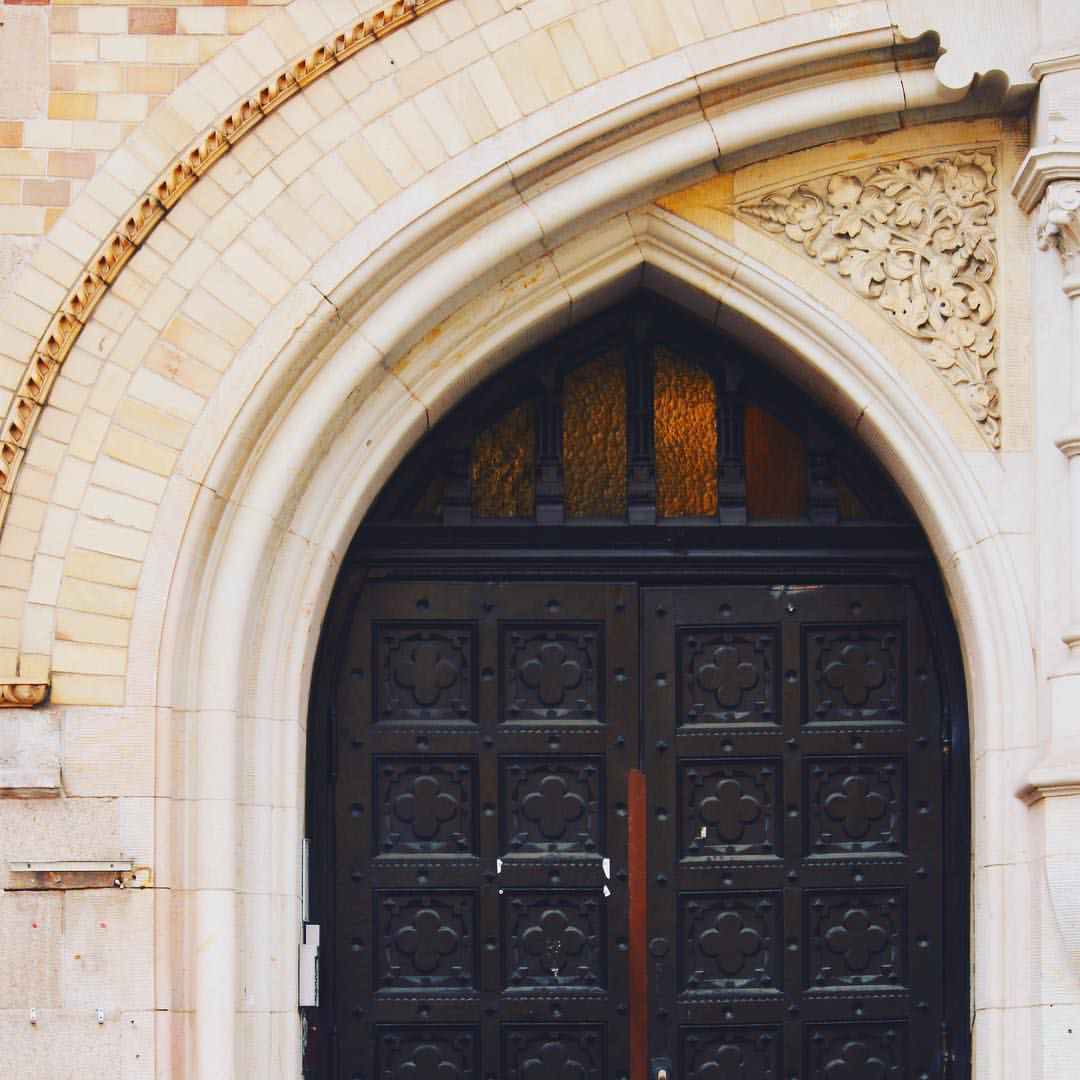

In [19]:
content_img

In [22]:
content_transform = transforms.Compose(
        [transforms.ToTensor(), transforms.Lambda(lambda x: x.mul(255))]
    )
content_img = content_transform(content_img)
content_img = content_img.unsqueeze(0)

In [23]:
output = style_model(content_img)[0].cpu()

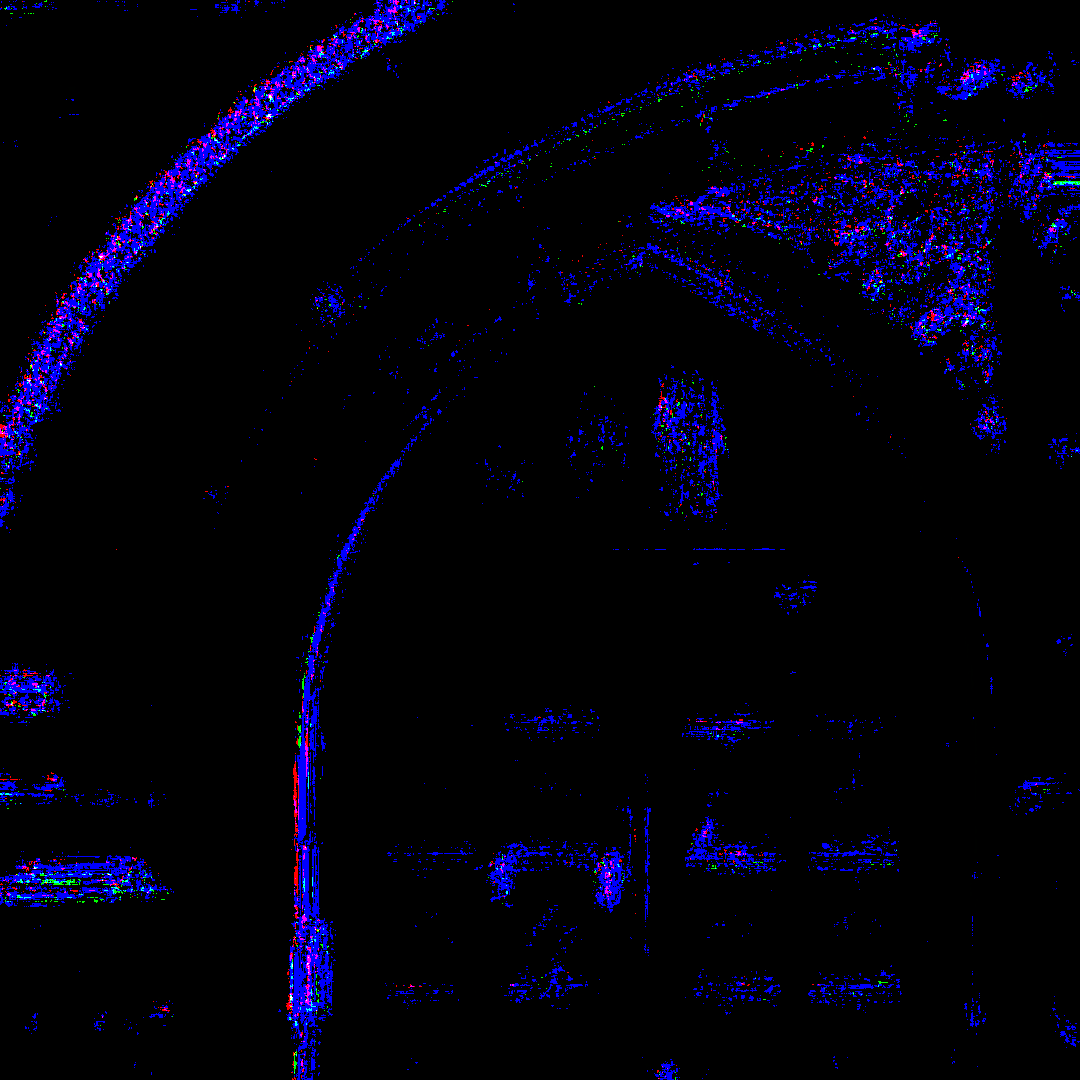

In [25]:
# Use this to directly show the image in the notebook
# The util function from the pytorch repository saves the image
# def get_img_from_tensor(out):
#     trans = transforms.ToPILImage()
#     img = 
#     return output.detach().clamp(0, 255).numpy().astype("uint8")

transforms.ToPILImage()(output.detach().numpy().astype("uint8").transpose(1, 2, 0))